In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [73]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore", category=UserWarning, module="scipy")
warnings.filterwarnings("ignore", category=UserWarning, module="albumentations")

# EDA

In [2]:
IMAGE_DIR1 = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images"
MASK_DIR1 = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks"

IMAGE_DIR2 = '/kaggle/input/cvcclinicdb/PNG/Original'
MASK_DIR2 = '/kaggle/input/cvcclinicdb/PNG/Ground Truth'

IMAGE_DIR3 = '/kaggle/input/merged-polyp-segmentation-datasets/images_valid/images_valid'
MASK_DIR3 =  '/kaggle/input/merged-polyp-segmentation-datasets/images_valid/masks_valid'

image_paths1 = sorted(glob(os.path.join(IMAGE_DIR1, "*.jpg")))
mask_paths1 = sorted(glob(os.path.join(MASK_DIR1, "*.jpg")))

print(f"Kvasir -> {len(image_paths1)} images, {len(mask_paths1)} masks")

image_paths2 = sorted(glob(os.path.join(IMAGE_DIR2, "*.png")))
mask_paths2  = sorted(glob(os.path.join(MASK_DIR2, "*.png")))

print(f"CVC -> {len(image_paths2)} images, {len(mask_paths2)} masks")

image_paths3 = sorted(glob(os.path.join(IMAGE_DIR3, "*.png")))
mask_paths3  = sorted(glob(os.path.join(MASK_DIR3, "*.png")))

print(f"MPSD -> {len(image_paths3)} images, {len(mask_paths3)} masks")

image_paths = image_paths1+image_paths2+image_paths3
mask_paths = mask_paths1 + mask_paths2 + mask_paths3
image_names = [os.path.basename(p) for p in image_paths]
mask_names = [os.path.basename(p) for p in mask_paths]
assert image_names == mask_names, "Image-mask filenames do not match!"

Kvasir -> 1000 images, 1000 masks
CVC -> 612 images, 612 masks
MPSD -> 22330 images, 22330 masks


In [20]:
data_info = []

def process_dataset(image_paths, mask_paths, dataset_name):
    for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths), desc=f"Processing {dataset_name}"):
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        
        
        img_np = np.array(img)
        mask_np = np.array(mask)
        
        
        h, w = img_np.shape[:2]
        
        
        mask_bin = (mask_np > 0).astype(np.uint8)
        coverage_ratio = mask_bin.sum() / (h * w)
        
        data_info.append({
            "filename": os.path.basename(img_path),
            "image_path": img_path,
            "mask_path": mask_path,
            "dataset": dataset_name,
            "width": w,
            "height": h,
            "aspect_ratio": w / h,
            "mask_coverage": coverage_ratio
        })



process_dataset(image_paths1, mask_paths1, "kvasir")
process_dataset(image_paths2, mask_paths2, "cvc")
process_dataset(image_paths3, mask_paths3, "mpsd")

df = pd.DataFrame(data_info)

Processing mpsd: 100%|██████████| 22330/22330 [01:30<00:00, 246.58it/s]


In [41]:
print("\n=== Dataset Summary ===")
print(df.describe())


=== Dataset Summary ===
              width        height  aspect_ratio  mask_coverage
count  23942.000000  23942.000000  23942.000000   23942.000000
mean     274.696350    268.898338      1.014547       0.113924
std       80.415834     60.804019      0.061155       0.119316
min      256.000000    256.000000      0.681725       0.000748
25%      256.000000    256.000000      1.000000       0.033173
50%      256.000000    256.000000      1.000000       0.074475
75%      256.000000    256.000000      1.000000       0.152172
max     1920.000000   1072.000000      1.791045       1.469482


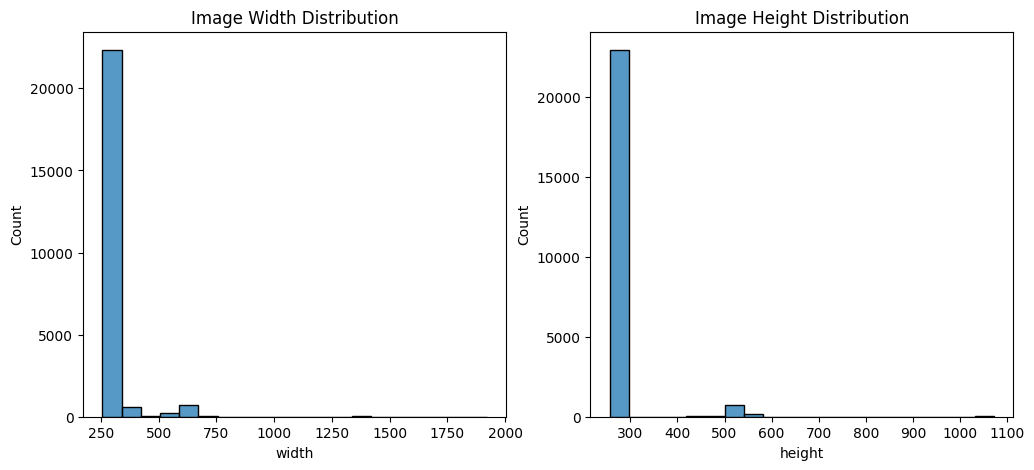

In [42]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df["width"], bins=20, kde=False)
plt.title("Image Width Distribution")

plt.subplot(1,2,2)
sns.histplot(df["height"], bins=20, kde=False)
plt.title("Image Height Distribution")
plt.show()

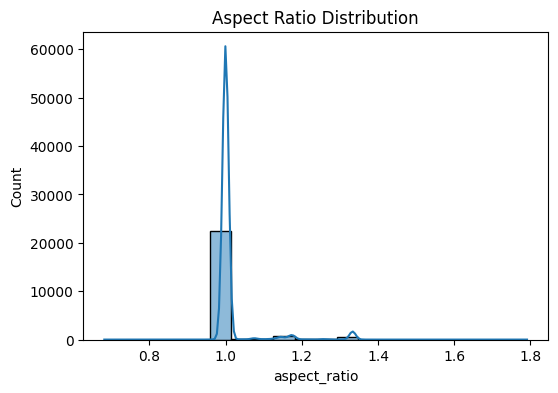

In [43]:
plt.figure(figsize=(6,4))
sns.histplot(df["aspect_ratio"], bins=20, kde=True)
plt.title("Aspect Ratio Distribution")
plt.show()

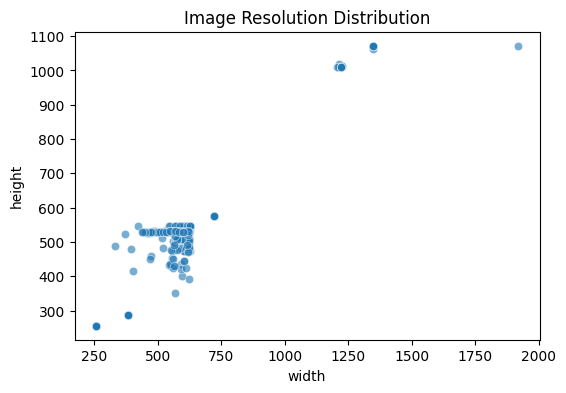

In [44]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="width", y="height", alpha=0.6)
plt.title("Image Resolution Distribution")
plt.show()

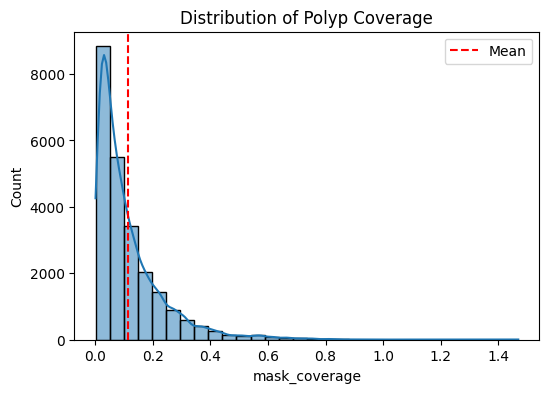

In [45]:
plt.figure(figsize=(6,4))
sns.histplot(df["mask_coverage"], bins=30, kde=True)
plt.axvline(df["mask_coverage"].mean(), color='r', linestyle='--', label="Mean")
plt.legend()
plt.title("Distribution of Polyp Coverage")
plt.show()

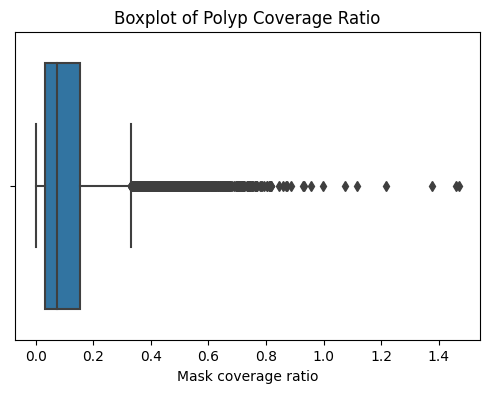

In [46]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["mask_coverage"])
plt.title("Boxplot of Polyp Coverage Ratio")
plt.xlabel("Mask coverage ratio")
plt.show()

In [47]:
empty_count = (df["mask_coverage"] <= 0.005).sum()
non_empty_count = (df["mask_coverage"] > 0.005).sum()

print(f"Empty masks: {empty_count} ({empty_count/len(df)*100:.2f}%)")
print(f"Non-empty masks: {non_empty_count} ({non_empty_count/len(df)*100:.2f}%)")

Empty masks: 460 (1.92%)
Non-empty masks: 23482 (98.08%)


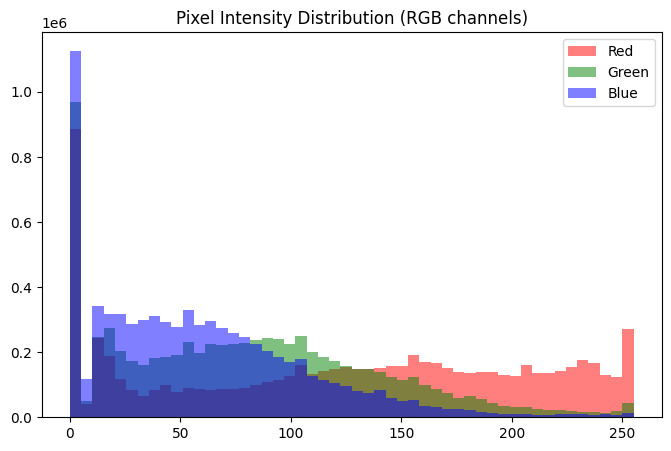

In [48]:
sample_imgs = np.random.choice(image_paths, size=100, replace=False)
pixels = []
for p in sample_imgs:
    img = cv2.imread(p)  # BGR
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels.append(img_rgb.reshape(-1, 3))
pixels = np.vstack(pixels)

plt.figure(figsize=(8,5))
plt.hist(pixels[:,0], bins=50, color='r', alpha=0.5, label='Red')
plt.hist(pixels[:,1], bins=50, color='g', alpha=0.5, label='Green')
plt.hist(pixels[:,2], bins=50, color='b', alpha=0.5, label='Blue')
plt.title("Pixel Intensity Distribution (RGB channels)")
plt.legend()
plt.show()

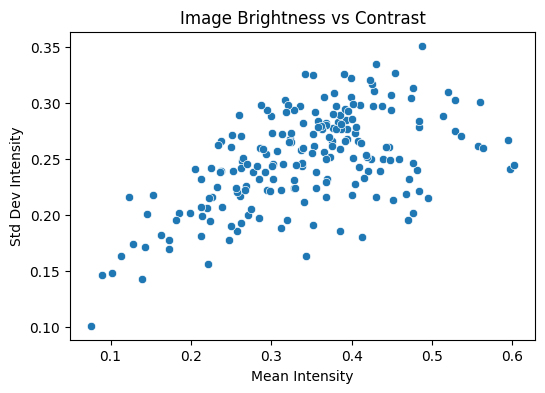

In [49]:
means, stds = [], []
for img_path in np.random.choice(image_paths, 200, replace=False):
    img = np.array(Image.open(img_path)) / 255.0
    means.append(img.mean())
    stds.append(img.std())

plt.figure(figsize=(6,4))
sns.scatterplot(x=means, y=stds)
plt.xlabel("Mean Intensity")
plt.ylabel("Std Dev Intensity")
plt.title("Image Brightness vs Contrast")
plt.show()

In [50]:
mask_values = []
for mask_path in np.random.choice(mask_paths, size=50, replace=False):
    mask = np.array(Image.open(mask_path))
    unique_vals = np.unique(mask)
    mask_values.extend(unique_vals.tolist())

mask_values = np.unique(mask_values)
print("\nUnique pixel values in masks:", mask_values)
if np.array_equal(mask_values, [0, 255]) or np.array_equal(mask_values, [0,1]):
    print("✅ Masks are binary.")
else:
    print("⚠️ Masks have unexpected values!")


Unique pixel values in masks: [  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]
⚠️ Masks have unexpected values!


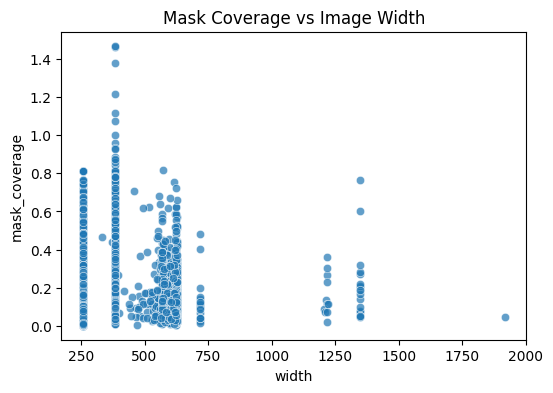

In [51]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="width", y="mask_coverage", alpha=0.7)
plt.title("Mask Coverage vs Image Width")
plt.show()

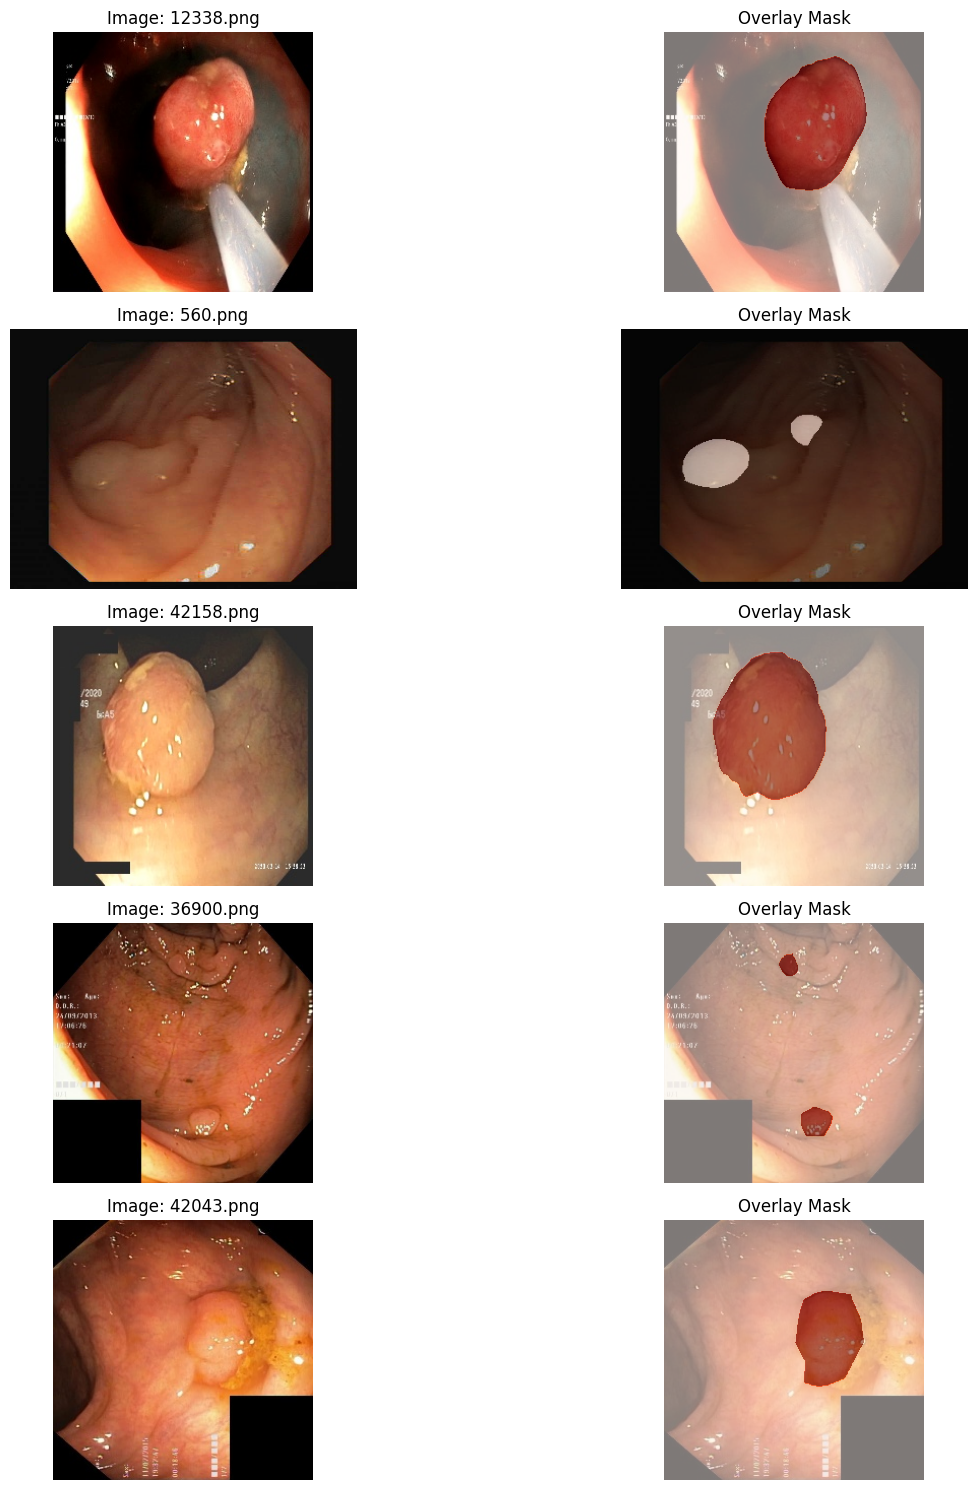

In [52]:
def visualize_samples(num_samples=5):
    samples = np.random.choice(len(image_paths), size=num_samples, replace=False)
    plt.figure(figsize=(15, num_samples*3))
    for i, idx in enumerate(samples):
        img = Image.open(image_paths[idx])
        mask = Image.open(mask_paths[idx])
        
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image: {os.path.basename(image_paths[idx])}")
        
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(img)
        plt.imshow(mask, cmap='Reds', alpha=0.5)
        plt.axis("off")
        plt.title("Overlay Mask")
    plt.tight_layout()
    plt.show()

visualize_samples(5)

/tmp/ipykernel_36/2861692189.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



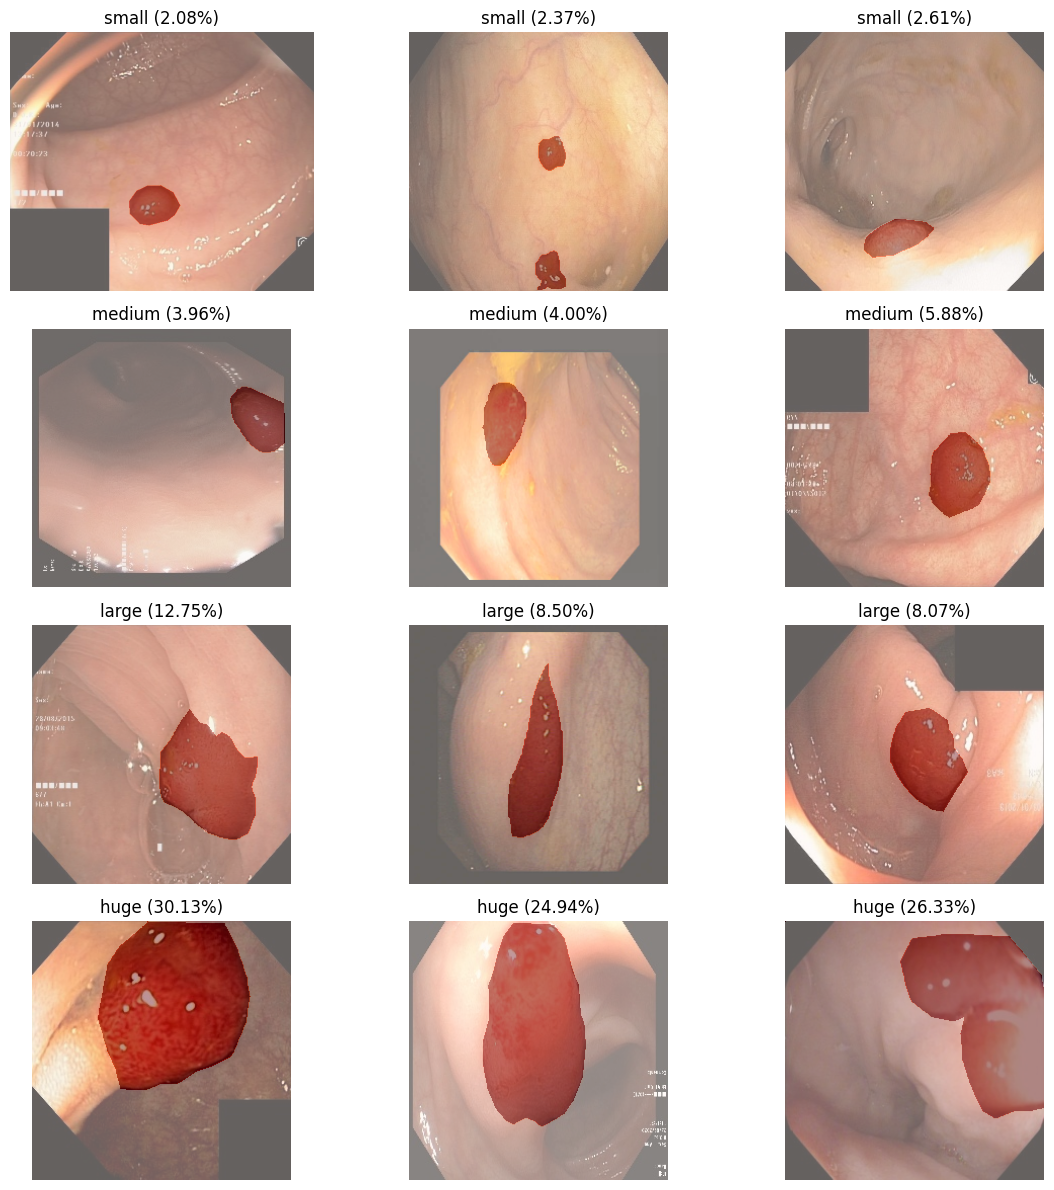

In [53]:
def load_image_and_mask(row):
    img = cv2.imread(row["image_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(row["mask_path"], cv2.IMREAD_GRAYSCALE)
    return img, mask

bins = pd.qcut(df["mask_coverage"], q=4, labels=["small", "medium", "large", 'huge'])
sample_idx = df.groupby(bins).apply(lambda x: x.sample(3, random_state=1)).index.get_level_values(1)

fig, axes = plt.subplots(4, 3, figsize=(12, 12))
for i, idx in enumerate(sample_idx):
    img, mask = load_image_and_mask(df.iloc[idx])
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.imshow(mask, cmap="Reds", alpha=0.4)
    ax.set_title(f"{bins.iloc[idx]} ({df['mask_coverage'].iloc[idx]:.2%})")
    ax.axis("off")
plt.tight_layout()

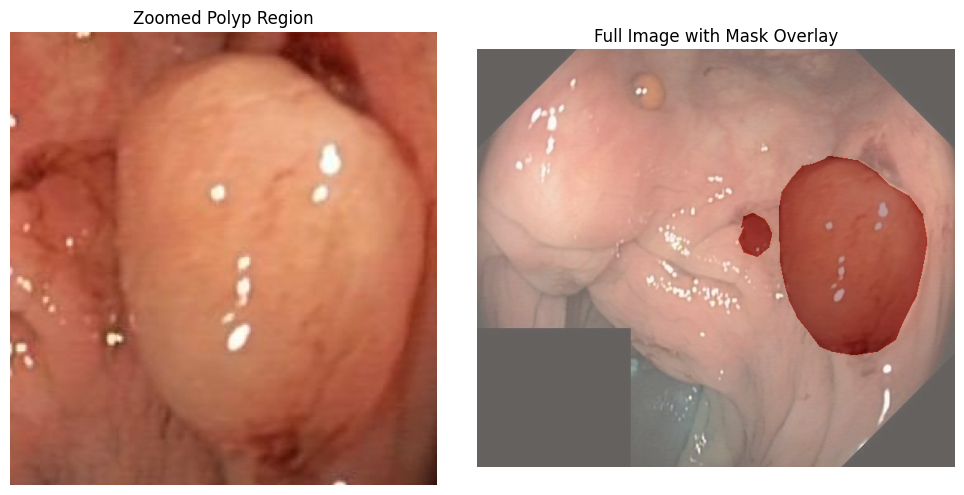

In [54]:
row = df[df['dataset']=='kvasir'].sample(1, random_state=0).iloc[0]
img = np.array(Image.open(row["image_path"]).convert("RGB"))
mask = np.array(Image.open(row["mask_path"]).convert("L"))


ys, xs = np.where(mask > 0)
if len(xs) > 0 and len(ys) > 0:

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    

    pad = 10
    x_min, x_max = max(0, x_min-pad), min(img.shape[1], x_max+pad)
    y_min, y_max = max(0, y_min-pad), min(img.shape[0], y_max+pad)
    
    masked_crop = img[y_min:y_max, x_min:x_max]
else:
 
    masked_crop = img

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(masked_crop)
ax1.set_title("Zoomed Polyp Region")
ax1.axis("off")

ax2.imshow(img)
ax2.imshow(mask, cmap="Reds", alpha=0.4)
ax2.set_title("Full Image with Mask Overlay")
ax2.axis("off")

plt.tight_layout()
plt.show()

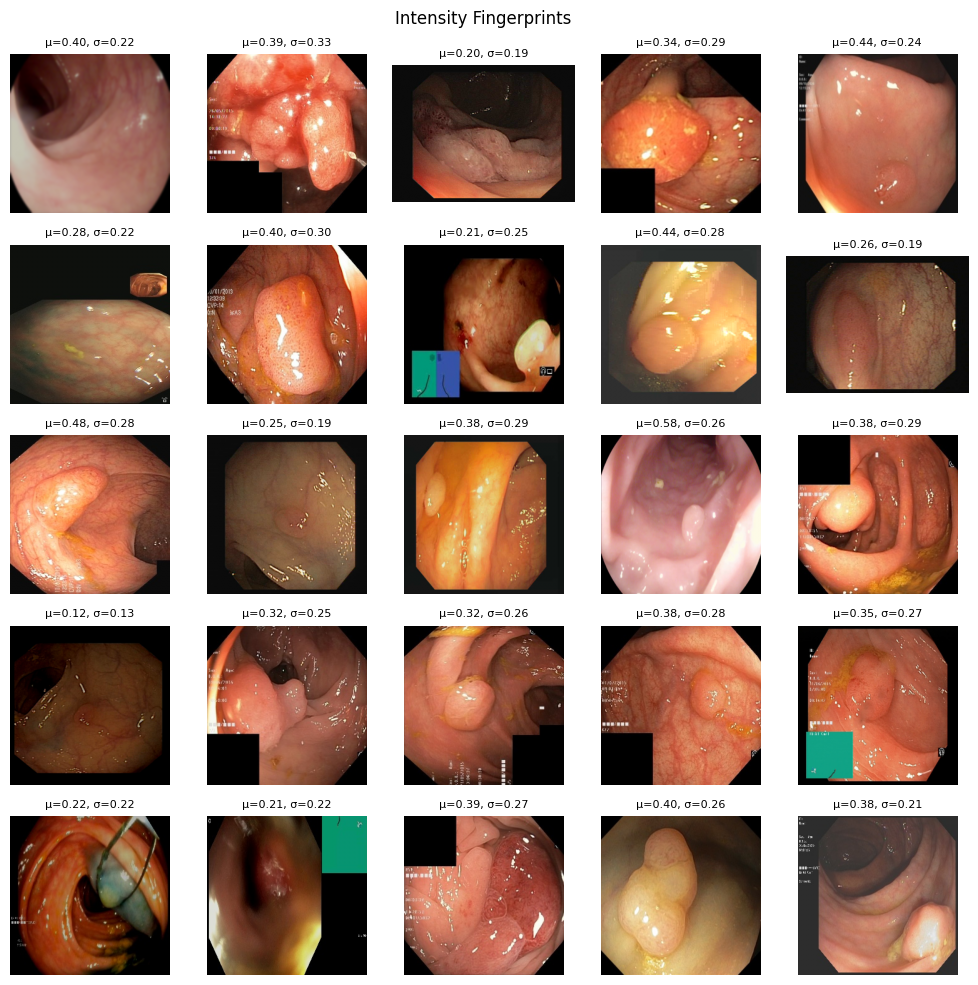

In [55]:
grid_size = 5
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10,10))
imgs = df.sample(n=grid_size**2, random_state=0)
for ax, (_, row) in zip(axes.flatten(), imgs.iterrows()):
    img = np.array(Image.open(row['image_path'])).astype(float)/255
    mean, std = img.mean(), img.std()
    ax.imshow(img)
    ax.set_title(f"μ={mean:.2f}, σ={std:.2f}", fontsize=8)
    ax.axis('off')
plt.suptitle("Intensity Fingerprints")
plt.tight_layout()
plt.show()

## hypo testing

### Kolmogorov–Smirnov Test: Are polyp sizes uniformly distributed?

#### Purpose

We want to understand whether polyp sizes in the dataset follow a normal distribution. This is important because many statistical methods assume normality, and model strategies (like data augmentation or stratified sampling) may depend on the distribution of polyp sizes. In medical imaging, datasets often have a skew toward small lesions, which can affect model performance.

#### Hypotheses

H₀ (null): Polyp coverage follows a normal distribution.

H₁ (alternative): Polyp coverage does not follow a normal distribution.

In [72]:
from scipy.stats import shapiro
stat, p = shapiro(df["mask_coverage"])

print(f"KS test (coverage vs uniform): {p:.3e}")

KS test (coverage vs uniform): 5.662e-100


Polyp coverage does not follow a normal distribution. The data is strongly skewed, with most polyps being small and a few large ones.

### Spearman Correlation: Do larger images tend to have larger polyps?

#### Purpose:
Since datasets often contain images from different cameras or settings, larger image resolutions might be associated with larger polyps. Understanding this helps us know if resolution introduces bias in polyp size distribution.

#### Hypotheses:

H₀: There is no monotonic relationship between image resolution (width × height) and polyp size (coverage).

H₁: There is a monotonic relationship between resolution and polyp size.

In [57]:
from scipy.stats import spearmanr

corr, p = spearmanr(df["width"]*df["height"], df["mask_coverage"])
print(f"Spearman correlation (Resolution vs Coverage): {corr:.3f}, p={p:.3e}")

Spearman correlation (Resolution vs Coverage): 0.169, p=1.071e-153


There is a weak but significant positive correlation: larger-resolution images tend to have slightly larger polyps.
This is not a strong biological effect but may indicate that some datasets (with higher resolution) contain larger lesions. For model building, this could create dataset bias where resolution and lesion size are confounded.

### T-test: Do portrait vs. landscape images differ in polyp coverage?

#### Purpose:
Images come in both portrait and landscape orientations. If orientation influences polyp coverage, it may point to differences in how images were captured or cropped (scanner/device bias).

#### Hypotheses:

H₀: Mean polyp coverage is the same in portrait and landscape images.

H₁: Mean polyp coverage is different between portrait and landscape images.

In [58]:
portrait = df[df["aspect_ratio"] < 1]["mask_coverage"]
landscape = df[df["aspect_ratio"] >= 1]["mask_coverage"]

from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(portrait, landscape, equal_var=False)
print(f"T-test (portrait vs landscape) p={p_val:.3f}")

T-test (portrait vs landscape) p=0.028


There is a statistically significant difference in polyp coverage between portrait and landscape images. The difference is small but suggests that orientation may introduce bias. For training, mixing orientations without balancing could lead to subtle model biases.

### Pearson Correlation: Is polyp size related to image contrast?

#### Purpose:
Image contrast (measured by pixel intensity standard deviation) affects model learning. We want to know whether larger polyps also tend to have higher/lower contrast, which could affect segmentation difficulty.

#### Hypotheses:

H₀: There is no linear relationship between polyp size and image contrast.

H₁: There is a linear relationship between polyp size and image contrast.

In [59]:
from scipy.stats import pearsonr
stds = []
for img_path in image_paths:
    img = np.array(Image.open(img_path)) / 255.0
    stds.append(img.std())
df["intensity_std"] = stds

corr, p = pearsonr(df["mask_coverage"], df["intensity_std"])
print(f"Correlation (mask coverage vs contrast): {corr:.3f}, p={p:.3e}")

Correlation (mask coverage vs contrast): 0.081, p=2.042e-36


There is a very weak but statistically significant positive correlation: larger polyps tend to have slightly higher contrast. This could mean that bigger lesions have more visible texture variation, but the effect is small. From a modeling perspective, this correlation is unlikely to provide strong predictive power.

# Preprosessing

In [60]:
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [61]:
class PolypDataset(Dataset):
    def __init__(self, datasets, transform=None, exts=("png","jpg","jpeg")):
        """
        General dataset for polyp segmentation.
        Supports multiple datasets at once.

        Args:
            datasets: list of (image_dir, mask_dir) tuples
            transform: Albumentations or similar transform
            exts: allowed image extensions
        """
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        for image_dir, mask_dir in datasets:
            image_paths, mask_paths = self._load_dataset(image_dir, mask_dir, exts)
            self.image_paths.extend(image_paths)
            self.mask_paths.extend(mask_paths)

    def _load_dataset(self, image_dir, mask_dir, exts):
        # Collect images
        image_paths = []
        for ext in exts:
            image_paths.extend(glob(os.path.join(image_dir, f"*.{ext}")))
        image_paths = sorted(image_paths)

        # Collect masks
        mask_paths = []
        for ext in exts:
            mask_paths.extend(glob(os.path.join(mask_dir, f"*.{ext}")))
        mask_paths = sorted(mask_paths)

        # Match by filename
        image_names = [os.path.basename(p) for p in image_paths]
        mask_dict = {os.path.basename(p): p for p in mask_paths}
        matched = [(img, mask_dict[os.path.basename(img)]) for img in image_paths if os.path.basename(img) in mask_dict]

        if matched:
            imgs, masks = zip(*matched)
        else:
            imgs, masks = [], []

        return list(imgs), list(masks)

    def __len__(self):
        return len(self.image_paths)

    def pad_to_square(self, img, color=(0, 0, 0)):
        h, w = img.shape[:2]
        size = max(h, w)
        top = (size - h) // 2
        bottom = size - h - top
        left = (size - w) // 2
        right = size - w - left
        return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    def __getitem__(self, idx):
        # Load image and mask
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Pad to square
        image = self.pad_to_square(image)
        mask = self.pad_to_square(mask, color=(0,))

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask.long()

In [74]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.2),
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.1, rotate_limit=15, 
        p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0
    ),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/tmp/ipykernel_36/3157186758.py:5: UserWarning:

Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate



In [63]:
from torch.utils.data import random_split

datasets = [
    ("/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images",
     "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks"),

    ("/kaggle/input/cvcclinicdb/PNG/Original",
     "/kaggle/input/cvcclinicdb/PNG/Ground Truth"),

    ("/kaggle/input/merged-polyp-segmentation-datasets/images_valid/images_valid",
     "/kaggle/input/merged-polyp-segmentation-datasets/images_valid/masks_valid"),
]

# full_dataset = KvasirDataset(IMAGE_DIR, MASK_DIR, transform=None)
full_dataset = PolypDataset(datasets, transform=None)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


train_dataset.dataset.transform = train_transform  
val_dataset.dataset.transform = val_transform     

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)


for images, masks in train_loader:
    print(images.shape)  # (B, 3, 512, 512)
    print(masks.shape)   # (B, 512, 512)
    break

torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


# train baseline model

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class ResUNet(nn.Module):
    def __init__(self, n_classes):
        super(ResUNet, self).__init__()
        base_model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        base_layers = list(base_model.children())

        self.layer0 = nn.Sequential(*base_layers[:3])  # [B, 64, 128, 128]
        self.layer1 = nn.Sequential(*base_layers[3:5]) # [B, 64, 64, 64]
        self.layer2 = base_layers[5]                    # [B, 128, 32, 32]
        self.layer3 = base_layers[6]                    # [B, 256, 16, 16]
        self.layer4 = base_layers[7]                    # [B, 512, 8, 8]

        self.upsample4 = self._upsample(512, 256)      # 8->16
        self.upsample3 = self._upsample(256, 128)      # 16->32
        self.upsample2 = self._upsample(128, 64)       # 32->64
        self.upsample1 = self._upsample(64, 64)        # 64->128

        # Additional upsample to go from 128->256 (to reach original input size)
        self.upsample0 = self._upsample(64, 64)        

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def _upsample(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x0 = self.layer0(x)  # 128x128
        x1 = self.layer1(x0) # 64x64
        x2 = self.layer2(x1) # 32x32
        x3 = self.layer3(x2) # 16x16
        x4 = self.layer4(x3) # 8x8

        x = self.upsample4(x4) + x3  # 16x16
        x = self.upsample3(x) + x2   # 32x32
        x = self.upsample2(x) + x1   # 64x64
        x = self.upsample1(x) + x0   # 128x128
        x = self.upsample0(x)        # 256x256

        return self.final_conv(x)    # [B, n_classes, 256, 256]


In [8]:
def iou_score(pred, target, threshold=0.5, smooth=1e-6):
    """
    Compute IoU for binary segmentation.
    pred: logits or probabilities of shape [B, H, W] or [B, 1, H, W]
    target: binary mask [B, H, W]
    """
    pred = torch.sigmoid(pred) if pred.dim() == 4 else pred  # apply sigmoid if logits
    pred = (pred > threshold).float()
    target = target.float()
    
    intersection = (pred * target).sum(dim=[1,2])   # sum over spatial dims
    union = pred.sum(dim=[1,2]) + target.sum(dim=[1,2]) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()


In [9]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResUNet(n_classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def dice_coeff(pred, target):
    smooth = 1.
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

train_losses, val_losses, val_dice,val_iou = [], [], [],[]

for epoch in range(10):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        # Convert masks to binary 0/1 long tensor
        masks = (masks > 0).long().to(device)

        optimizer.zero_grad()
        outputs = model(images)  # outputs shape: [B, 2, 256, 256]
        loss = F.cross_entropy(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss, dice,iou = 0, 0,0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = (masks > 0).long().to(device)
            outputs = model(images)
            loss = F.cross_entropy(outputs, masks)
            val_loss += loss.item()
            pred_logits = outputs[:, 1, :, :]
            dice += dice_coeff(pred_logits, masks).item()
            iou += iou_score(pred_logits, masks)

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_dice.append(dice / len(val_loader))
    val_iou.append(iou/ len(val_loader))
    

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Dice: {val_dice[-1]:.4f} | IOU: {val_iou[-1]:.4f}")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 186MB/s]
100%|██████████| 2395/2395 [02:24<00:00, 16.61it/s]


Epoch 1 | Train Loss: 0.1158 | Val Loss: 0.0627 | Dice: 0.8801 | IOU: 0.6787


100%|██████████| 2395/2395 [02:21<00:00, 16.95it/s]


Epoch 2 | Train Loss: 0.0568 | Val Loss: 0.0599 | Dice: 0.8903 | IOU: 0.7664


100%|██████████| 2395/2395 [02:21<00:00, 16.92it/s]


Epoch 3 | Train Loss: 0.0437 | Val Loss: 0.0482 | Dice: 0.9092 | IOU: 0.7673


100%|██████████| 2395/2395 [02:21<00:00, 16.98it/s]


Epoch 4 | Train Loss: 0.0366 | Val Loss: 0.0430 | Dice: 0.9207 | IOU: 0.7902


100%|██████████| 2395/2395 [02:20<00:00, 17.01it/s]


Epoch 5 | Train Loss: 0.0321 | Val Loss: 0.0571 | Dice: 0.9043 | IOU: 0.8094


100%|██████████| 2395/2395 [02:20<00:00, 16.99it/s]


Epoch 6 | Train Loss: 0.0311 | Val Loss: 0.0393 | Dice: 0.9295 | IOU: 0.8084


100%|██████████| 2395/2395 [02:21<00:00, 16.98it/s]


Epoch 7 | Train Loss: 0.0248 | Val Loss: 0.0432 | Dice: 0.9228 | IOU: 0.8103


100%|██████████| 2395/2395 [02:20<00:00, 17.00it/s]


Epoch 8 | Train Loss: 0.0268 | Val Loss: 0.0385 | Dice: 0.9318 | IOU: 0.8219


100%|██████████| 2395/2395 [02:21<00:00, 16.88it/s]


Epoch 9 | Train Loss: 0.0225 | Val Loss: 0.0358 | Dice: 0.9393 | IOU: 0.8374


100%|██████████| 2395/2395 [02:21<00:00, 16.91it/s]


Epoch 10 | Train Loss: 0.0220 | Val Loss: 0.0384 | Dice: 0.9366 | IOU: 0.8324


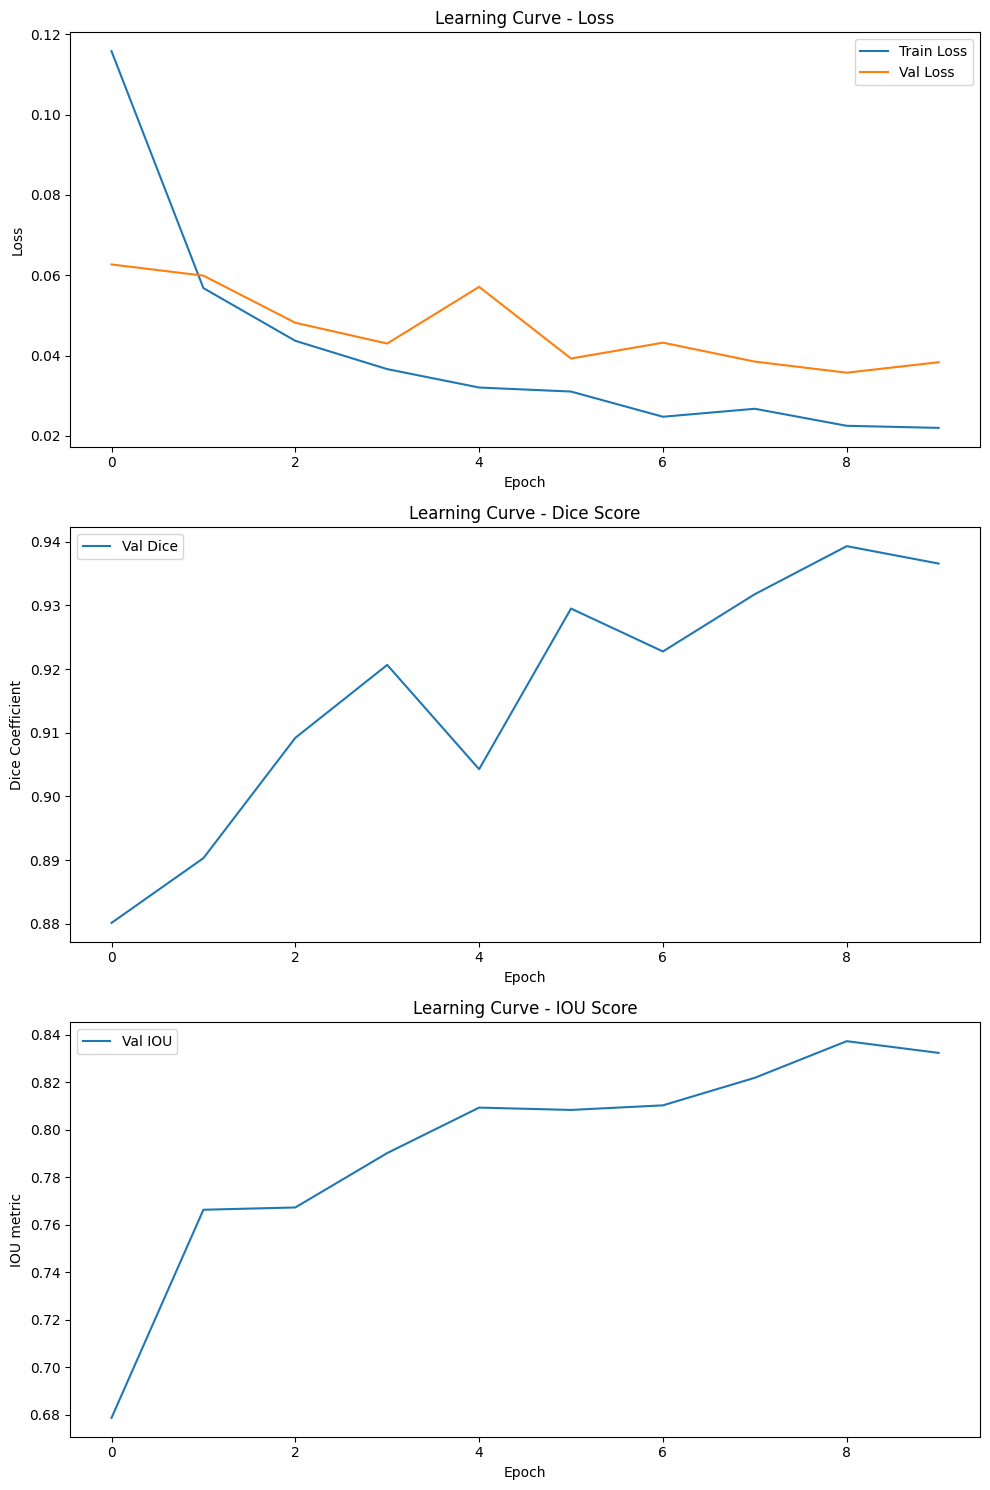

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 rows, 1 column

# --- Loss ---
axes[0].plot(train_losses, label="Train Loss")
axes[0].plot(val_losses, label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_title("Learning Curve - Loss")

# --- Dice ---
axes[1].plot(val_dice, label="Val Dice")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Dice Coefficient")
axes[1].legend()
axes[1].set_title("Learning Curve - Dice Score")

# --- IOU ---
axes[2].plot(val_iou, label="Val IOU")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("IOU metric")
axes[2].legend()
axes[2].set_title("Learning Curve - IOU Score")

plt.tight_layout()
plt.show()